# Thinkful DS Bootcamp: Housing Price Capstone Project

## Abstract
A house is usually the most expensive and valuable property traded by an individual in his or her lifetime. Decisions on a housing transaction are incredibly critical to managing one's property. There are countless and complicated parameters related to housing price; it is one of the most stressful job to make a crucial decision by oneself because we only have unscientific and empirical evidence about the prescribed trade. As a result, it is the reason real estate databases companies including Zillow growth rapidly with their transaction dataset and predictive models. 


I analyze a dependent parameter, "SalePrice" from the dataset. I also search representative parameters correlated to the housing price such as "OveralQual", rates the overall material and finish of the house, and "GrLivAre", above ground living area, and their "Neighborhood". Moreover, the statistical difference in house trade between seasons is tested. Lastly, I propose a A/B test on house commercials with highlight on parameters.

**Reference:** The following project examines the dependent variable "SalePrice" in a statistical view from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques), the Ames Housing Dataset compiled by Dean De Cock. The dataset includes housing transactions traded from Jan 2006 to Jul 2010. 

**Keywords:** exploratory data analysis, feature engineering, data visualization, A/B test.

## Checking the Dataset

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
# import the train dataset into pandas dataframe & check the architecture of the dataset
train = pd.read_csv('./Data/train.csv')
print(train.shape)

(1460, 81)


After importing the train dataset downloaded from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques), we can check the shape of the housing dataframe; there are 1460 rows (equal to cases) and 81 columns. Is there any duplicated data? Check it with transaction ID, a variable "Id"!

In [3]:
train.Id.duplicated().sum()

0

Great! There isn't any duplicated case and we don't have to filter any case for the analysis, totally 1460 cases. By the way, how many independent parameter we have?

In [4]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Amazingly, there are 79 independent parameters are listed as columns except "Id" and "SalePrice". OMG! How can we hand this overflowing data, 1460 x (79 + 1), to my housing price from this overflowing data! With three analytical questions, let me look the data deeper! Before that, I drop "Id" column from the dataset.

In [5]:
train_Id = train.Id
train.drop('Id', axis = 1, inplace = True)

### Analytic Q1. Who are you, "SalePrice"?!

The dependent variable "SalePrice" is our target in this project. So, we need to know this specifically with our statistical eyes.

In [6]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

We can get descriptive statistics of "SalePrice". Tere is huge difference between its mean and median; it seems like positive skewed! (because the mean is bigger.). Let's check the skewness.

In [7]:
print('Skewness: ', train['SalePrice'].skew())

Skewness:  1.88287575977


As I mentioned, yes, there is strong postive skewness!. It means the distribution of "SalePrice" is far away from normal distribution. What does the distribution of "SalePrice" truely look like?

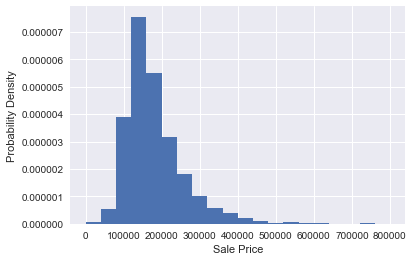

In [8]:
plt.hist(train['SalePrice'], bins = 20, range= (0,800000), normed =  True)
plt.xlabel('Sale Price')
plt.ylabel('Probability Density')
plt.show()

Oh! I see. The prescribed distribution seems like lognormal distribution!

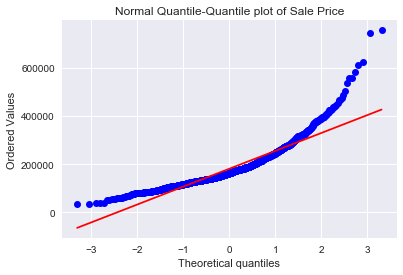

In [9]:
stats.probplot(train['SalePrice'], dist="norm", plot=plt)
plt.title('Normal Quantile-Quantile plot of Sale Price')
plt.show()

QQ plot of "SalePrice" has strong deviation from the trend line, it indicates that the data is not normal. Specially, it has strong upper tail. 

Even though its non-Gaussian distribution, it seems closed lognormal distribution. When we apply log function on the variable, it would have a noraml distribution.

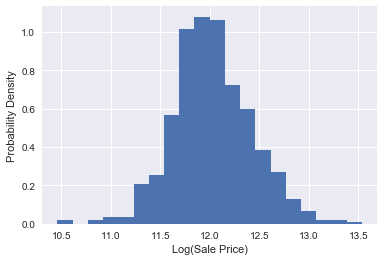

In [10]:
plt.hist(np.log(train['SalePrice']), bins = 20, normed =  True)
plt.xlabel('Log(Sale Price)')
plt.ylabel('Probability Density')
plt.show()

As you can see, it becomes much closer to normal shape!

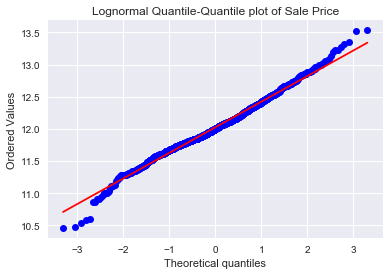

In [11]:
stats.probplot(np.log(train['SalePrice']), dist="norm", plot=plt)
plt.title('Lognormal Quantile-Quantile plot of Sale Price')
plt.show()

The QQ plot with the new variable, log-SalePrice, falls in to a straight line. So, we will use the new parameter as our new dependent one, "LSalePrice" in the following analysis.

In [12]:
# Generate a new column, LSalePrice in the train dataset
train['LSalePrice'] = np.log(train['SalePrice'])
# Drop the 'SalePrice' column
train.drop('SalePrice', axis = 1, inplace = True)

### Analytic Q2. which paremeter is related to "LSalePrice"?!

In this prep capstone project, we have 79 features of house including quantative and categorical features. Among 79 parameters, I decide to check their relationship with the "LSalePrice" with univarate analysis.

**1. Parameter: "GrLivArea"**

What factor we usually consider to choose our own house? Living area!. As a representative quantitative parameter, "GrLivArea" means living area above ground. Generally, the total living area of the dwelling is above ground level except basement or attic. Using scatter plot, let's see the linear relationship between "GrLivArea" and "LSalePrice".

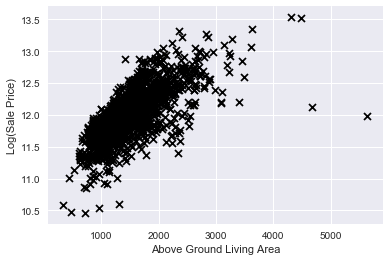

In [13]:
# scatter plot between GrLivArea and LSalePrice
data_LSalePrice_GrLivArea = pd.concat([train['LSalePrice'], train['GrLivArea']], axis=1)
plt.scatter(x = data_LSalePrice_GrLivArea['GrLivArea'], y = data_LSalePrice_GrLivArea['LSalePrice'], marker ='x', color='k')
plt.xlabel('Above Ground Living Area')
plt.ylabel('Log(Sale Price)')
plt.show()

We can see that "GrLivArea" has strong linear correlation with "LSalePrice". However, we also find the two outliers whose "GrLivArea" are bigger than 4500.

In [14]:
# check the outliers
train[data_LSalePrice_GrLivArea['GrLivArea'] > 4500]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LSalePrice
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,12.126759
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,11.982929


The transactions with Id number 524 and 1299 are exceptional, but, I couldn't find any specific reason why they becomes outliers. So, we may need to filter them out to build linear regression model for SalePrice. However, we do not consider the data filtering on these cases in the current project.

**2. Parameter: "OverallQual"**

"OverallQual" is one of the most correlated catagorical values with "SalePrice"; it means rates the overall material and finish of the house. With multiple boxplots of different grade, we can see its positive correlation between "OverallQual" and "LSalePrice". Additionaly, most transactions have mid-grade as "OverallQual".

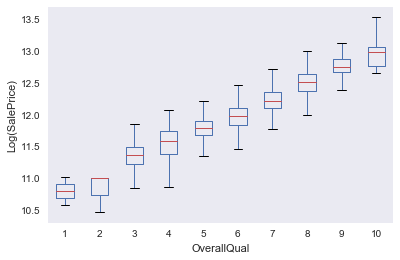

In [15]:
# boxplots between OverallQual and LSalePrice
data_SalePrice_OverallQual = pd.concat([train['LSalePrice'], train['OverallQual']], axis=1)
data_SalePrice_OverallQual.boxplot(column = 'LSalePrice', by='OverallQual')
plt.grid(False)
plt.suptitle('')
plt.title('')
plt.ylabel('Log(SalePrice)')
plt.show()

**3. Parameter: "Neighborhood"**

Another categorical parameter are considered, that is "Neighborhood", means physical locations within Ames city limits.

In [16]:
data_SalePrice_Neighborhood = pd.concat([np.log(train['LSalePrice']), train['Neighborhood']], axis=1)

In [17]:
# list of Neighborhood
list_Neighbor = list(data_SalePrice_Neighborhood.groupby('Neighborhood').count().index)
print(list_Neighbor)

['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']


In [18]:
# dictionary of Neighborhood
dict_Neighbor = dict( zip(list_Neighbor,list(range(len(list_Neighbor)))) )
print(dict_Neighbor)

{'Blmngtn': 0, 'Blueste': 1, 'BrDale': 2, 'BrkSide': 3, 'ClearCr': 4, 'CollgCr': 5, 'Crawfor': 6, 'Edwards': 7, 'Gilbert': 8, 'IDOTRR': 9, 'MeadowV': 10, 'Mitchel': 11, 'NAmes': 12, 'NPkVill': 13, 'NWAmes': 14, 'NoRidge': 15, 'NridgHt': 16, 'OldTown': 17, 'SWISU': 18, 'Sawyer': 19, 'SawyerW': 20, 'Somerst': 21, 'StoneBr': 22, 'Timber': 23, 'Veenker': 24}


To compare the dependency between each "Neighborhood" and "LSalePrice", we replace string "Neighborhood" to integer "Simple_Neighborhood", but it is sorted by alphabet order.

In [19]:
data_SalePrice_Neighborhood['Simple_Neighborhood'] = \
data_SalePrice_Neighborhood.Neighborhood.replace(dict_Neighbor)

In [20]:
data_SalePrice_Neighborhood.head(10)

,LSalePrice,Neighborhood,Simple_Neighborhood
0,2.505338,CollgCr,5
1,2.493950,Veenker,24
2,2.510994,CollgCr,5
3,2.472277,Crawfor,6
4,2.520050,NoRidge,15
5,2.474065,Mitchel,11
6,2.536439,Somerst,21
7,2.501934,NWAmes,14
8,2.465938,OldTown,17
9,2.457744,BrkSide,3


Let's draw the boxplots of "neighborhood"!

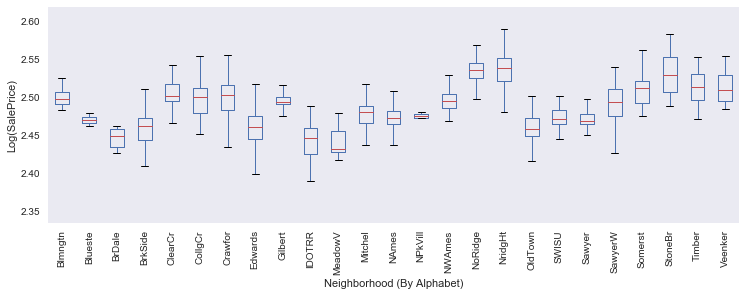

In [21]:
# boxplot between Neighborhood and LSalePrice
# sorted by Alphabet
data_SalePrice_Neighborhood.boxplot(column = 'LSalePrice', by='Simple_Neighborhood', figsize=(12,4))
plt.grid(False)
plt.suptitle('')
plt.title('')
plt.ylabel('Log(SalePrice)')
plt.xlabel('Neighborhood (By Alphabet)')
locs, labels = plt.xticks()  
plt.xticks(locs, list_Neighbor, rotation = 90)
plt.show()

While the boxplots are clustered around their own median, they are placed randomly. So, I decide to draw boxplots sorted by their repective median.

In [22]:
median_SalePrice_groupby_Neighborhood = data_SalePrice_Neighborhood.groupby('Neighborhood').LSalePrice.median()
print(median_SalePrice_groupby_Neighborhood.sort_values())

Neighborhood
MeadowV    2.432305
IDOTRR     2.446035
BrDale     2.448519
OldTown    2.458467
Edwards    2.460410
BrkSide    2.462166
Sawyer     2.469203
Blueste    2.470311
SWISU      2.471975
NAmes      2.472277
NPkVill    2.475812
Mitchel    2.480016
SawyerW    2.493218
Gilbert    2.493722
NWAmes     2.494584
Blmngtn    2.498154
CollgCr    2.500777
ClearCr    2.502036
Crawfor    2.502189
Veenker    2.508969
Somerst    2.511717
Timber     2.512780
StoneBr    2.528555
NoRidge    2.535007
NridgHt    2.538473
Name: LSalePrice, dtype: float64


In [23]:
list_Neighbor_sorted = list(median_SalePrice_groupby_Neighborhood.sort_values().index)
dict_Neighbor_sorted = dict( zip(list_Neighbor_sorted,list(range(len(list_Neighbor_sorted)))) )
print(dict_Neighbor_sorted)

{'MeadowV': 0, 'IDOTRR': 1, 'BrDale': 2, 'OldTown': 3, 'Edwards': 4, 'BrkSide': 5, 'Sawyer': 6, 'Blueste': 7, 'SWISU': 8, 'NAmes': 9, 'NPkVill': 10, 'Mitchel': 11, 'SawyerW': 12, 'Gilbert': 13, 'NWAmes': 14, 'Blmngtn': 15, 'CollgCr': 16, 'ClearCr': 17, 'Crawfor': 18, 'Veenker': 19, 'Somerst': 20, 'Timber': 21, 'StoneBr': 22, 'NoRidge': 23, 'NridgHt': 24}


In [24]:
data_SalePrice_Neighborhood['Simple_Neighborhood_sorted'] = \
data_SalePrice_Neighborhood.Neighborhood.replace(dict_Neighbor_sorted)
data_SalePrice_Neighborhood.head(10)

,LSalePrice,Neighborhood,Simple_Neighborhood,Simple_Neighborhood_sorted
0,2.505338,CollgCr,5,16
1,2.493950,Veenker,24,19
2,2.510994,CollgCr,5,16
3,2.472277,Crawfor,6,18
4,2.520050,NoRidge,15,23
5,2.474065,Mitchel,11,11
6,2.536439,Somerst,21,20
7,2.501934,NWAmes,14,14
8,2.465938,OldTown,17,3
9,2.457744,BrkSide,3,5


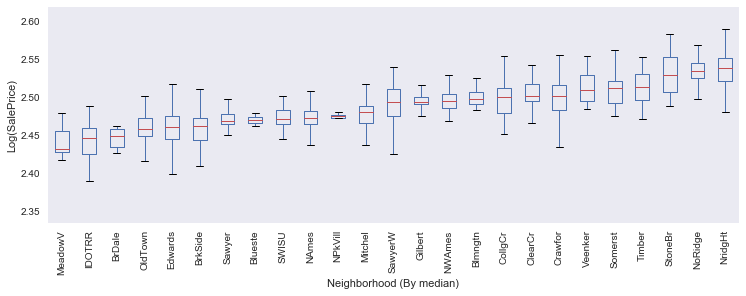

In [25]:
data_SalePrice_Neighborhood.boxplot(column = 'LSalePrice', by='Simple_Neighborhood_sorted', figsize=(12,4))
plt.grid(False)
plt.suptitle('')
plt.title('')
plt.ylabel('Log(SalePrice)')
plt.xlabel('Neighborhood (By median)')
locs, labels = plt.xticks()  
plt.xticks(locs, list_Neighbor_sorted, rotation = 'vertical')
plt.show()

Now, it is robust that there is strong correlation between "Neighborhood" and "LSalePrice".

### Analytic Q3. Is there statistically difference among seasons?

To further explore in the dataset, I hope to check wheather there is a meaningful difference among seasonal "SalePrice"s. Let us do a t-test on the two groups, "Spring & Summer" and "Autumn & Winter".

First, we have incomplete dataset of 2010, because the transaction in 2010 only are collected until July. 

In [26]:
LSalePrice_MoSold_YrSold = pd.concat([train['LSalePrice'], train['MoSold'], train['YrSold']], axis=1) 
print(LSalePrice_MoSold_YrSold.groupby(['YrSold', 'MoSold']).count())

               LSalePrice
YrSold MoSold            
2006   1               10
       2                9
       3               25
       4               27
       5               38
       6               48
       7               67
       8               23
       9               15
       10              24
       11              16
       12              12
2007   1               13
       2                8
       3               23
       4               23
       5               43
       6               59
       7               51
       8               40
       9               11
       10              16
       11              24
       12              18
2008   1               13
       2               10
       3               18
       4               26
       5               38
       6               51
       7               49
       8               29
       9               17
       10              22
       11              17
       12              14
2009   1    

So, I filtered out the cases traded in 2010.

In [27]:
LSalePrice_MoSold_YrSold_wo2010 = LSalePrice_MoSold_YrSold[ LSalePrice_MoSold_YrSold.YrSold != 2010]
print(LSalePrice_MoSold_YrSold_wo2010.groupby(['YrSold', 'MoSold']).count())

               LSalePrice
YrSold MoSold            
2006   1               10
       2                9
       3               25
       4               27
       5               38
       6               48
       7               67
       8               23
       9               15
       10              24
       11              16
       12              12
2007   1               13
       2                8
       3               23
       4               23
       5               43
       6               59
       7               51
       8               40
       9               11
       10              16
       11              24
       12              18
2008   1               13
       2               10
       3               18
       4               26
       5               38
       6               51
       7               49
       8               29
       9               17
       10              22
       11              17
       12              14
2009   1    

There is fluctuation in total number of transaction according to month! The number of trade starts to increase from March and decrease from August.

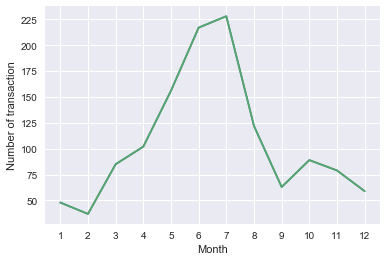

In [28]:
plt.plot(LSalePrice_MoSold_YrSold_wo2010.groupby('MoSold').count())
plt.xlabel('Month')
plt.ylabel('Number of transaction')
plt.xticks(np.arange(1,13))
plt.show()

Therefore, I divide the cases to two kinds of groups:"Spring & Summer", from Mar to Aug, and "Autumn & Winter", from Sep to Feb.

In [29]:
LSalePrice_MoSold_YrSold_wo2010['SeasSold'] = LSalePrice_MoSold_YrSold_wo2010.MoSold.replace({3:0, 4:0, 5:0, 
                                                                                             6:0, 7:0, 8:0, 
                                                                                             9:1, 10:1, 11:1, 
                                                                                             12:1, 1:1, 2:1,})
print(LSalePrice_MoSold_YrSold_wo2010.head(10))

   LSalePrice  MoSold  YrSold  SeasSold
0   12.247694       2    2008         1
1   12.109011       5    2007         0
2   12.317167       9    2008         1
3   11.849398       2    2006         1
4   12.429216      12    2008         1
5   11.870600      10    2009         1
6   12.634603       8    2007         0
7   12.206073      11    2009         1
8   11.774520       4    2008         0
9   11.678440       1    2008         1


/Users/hwanpyokim/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Now, let's compare the number of trade betwen the prescribed two groups. The total number of transaction during spring and summer, 910 is more than double the one during autumn and winter, 375.

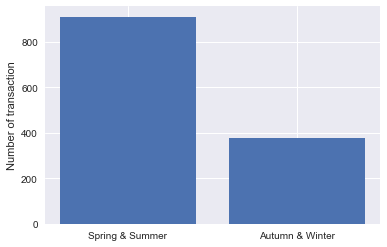

In [30]:
plt.bar((0,1), LSalePrice_MoSold_YrSold_wo2010.groupby('SeasSold').count().iloc[:,0])
plt.ylabel('Number of transaction')
plt.xticks((0,1), ('Spring & Summer', 'Autumn & Winter'))
plt.show()

Similar to the difference within the number of trade, is there statistically meaningful difference of housing price between the two? First, compare their boxplots!

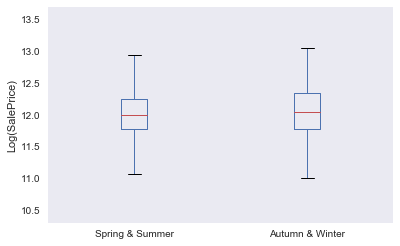

In [31]:
LSalePrice_MoSold_YrSold_wo2010.boxplot(column = 'LSalePrice', by='SeasSold')
plt.grid(False)
plt.suptitle('')
plt.title('')
plt.xlabel('')
plt.ylabel('Log(SalePrice)')
locs, labels = plt.xticks()  
plt.xticks(locs, ('Spring & Summer', 'Autumn & Winter'))
plt.show()

Even though we can recognize there are more outliers in the group, spring & summer, it doesn't seems strong differences of median and IQR. Let us do a t-test between the different seasons!

In [32]:
LSalePrice_SS = LSalePrice_MoSold_YrSold_wo2010.LSalePrice[LSalePrice_MoSold_YrSold_wo2010.SeasSold == 0]
LSalePrice_AW = LSalePrice_MoSold_YrSold_wo2010.LSalePrice[LSalePrice_MoSold_YrSold_wo2010.SeasSold == 1]

In [33]:
stats.ttest_ind(LSalePrice_SS, LSalePrice_AW, equal_var=False)

Ttest_indResult(statistic=-1.1544636470391187, pvalue=0.2487433094385898)

The t-test is for normal distribution, and "LSalePrice" of the two seasons are quite normal distributions. From the t-test, we have p-value is 0.249, is too big to decline the null hypotheses. Therefore, we cannot be confident in the difference in means is statistically significant!


### Analytical Q4:  Research Proposal - How can we increase the number of house trade?
**Background**
Let's assume I am a data scientist at a famous real estate company in Ames, Iowa and my team is looking for the best strategy to increase sale and maximize profit of the company.

So far, we analyzed the relationship between logarithmic housing price, "LSalePrice" and a series of parameters. 
Furthermore, to find out the parameter which are mostly correlated parameters in the dataset, I calcualte the correlation matrix and plot it using heatmap in Seaborn. 

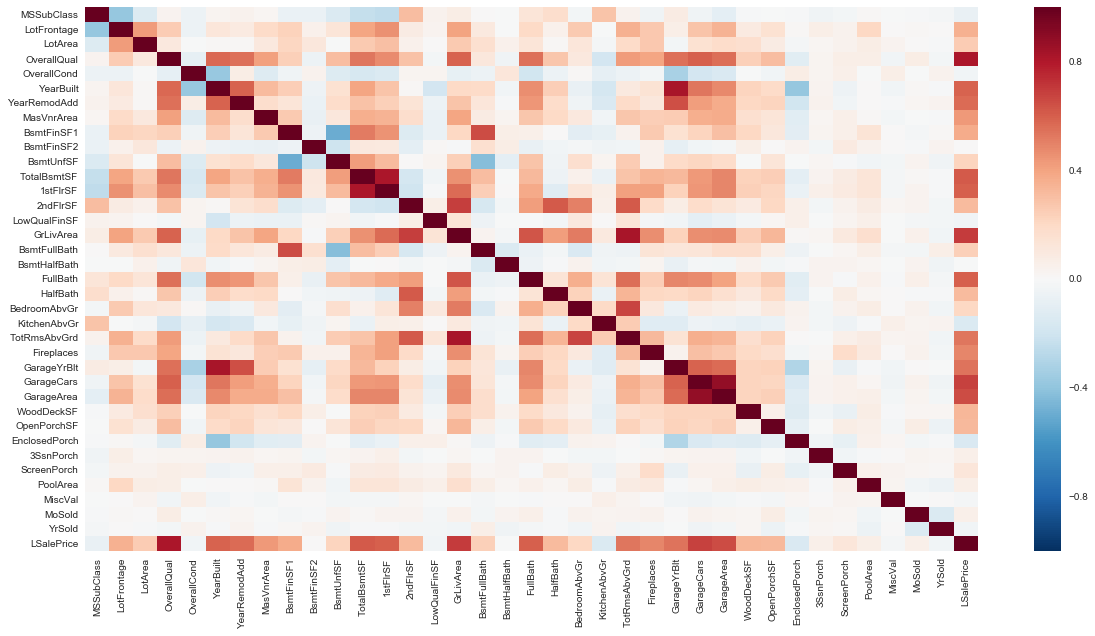

In [34]:
plt.subplots(figsize=(20,10))
corr_train = train.corr()
sns.heatmap(corr_train)
plt.show()

To see the level of correlation with "LSalePrice", let's arrange the index in the matrix by sorting the values with the target.

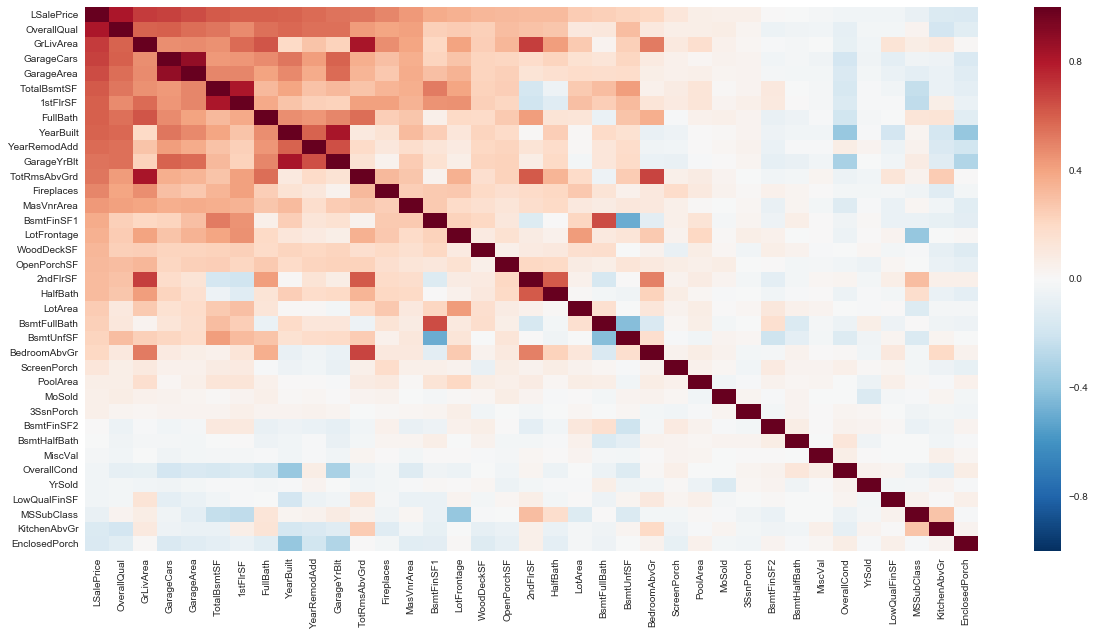

In [35]:
Sort_corr_cols = corr_train['LSalePrice'].sort_values(ascending=False).drop(['LSalePrice']).index
Sort_corr_cols = list(Sort_corr_cols)
Sort_corr_cols.insert(0,'LSalePrice')

plt.subplots(figsize=(20,10))
sns.heatmap(train[Sort_corr_cols].corr())
plt.show()

So, the top 3 mostly correlated parameters with "LSalePrice" are "OveralQual", "GrLivArea", and "GarageCars".

**Hypothesis**
There are several parameters related to the house price, so as a data scientist, I need to find out the most correlated parameter with the price and emphasize it in a sale advertisement of the house to increase sales of the houses.

** Rollout Plan**
Knowing the mostly considered parameters in house sales and advertise them is important to tempt our future customers to purchase houses. So, we can set an A/B test as building two versions of commercials; one emphasizes the top 3 parameters of houses, "LSalePrice", "OveralQual", and "GarageCars" and the other doese not.


We need to be careful in the experiment, we will only select 10% of houses in the company at random and perform the prescribed test during the first month. In a t-test, if we found out the difference within the two sales figures with an extreme p-value (p <= 0.05) , we will apply the test at 50% for two month. We could get 200+ cases totally.

* Principal Metric:
The key metric in this experiment is the number of sales.

* Second Metric: We also need to check how long the customers spend to make their decision. 



### Future Rearsearch


So far, I found out the normality of "LSalePrice", logarithmic "SalePrice", and checked its correlations with representative parameters. Furthermore, we validated that there is no statistical difference between seasonal housing prices. Lastly, I propose a A/B test on housing commercials with highlighted parameters.

How could I use data to help make an efficient decision in housing? We need to do univariate & multivariate analysis on all of the parameters. I only choose the prescribed 3 variables as featuring analysis among 79 parameters. However, we could find out another factor which affects the price.

The number of cases in the Ames housing dataset is quite limited, so I should consider more significant dataset such as Zillow's one with more row to build stronger statistical confidence.

A few of factors includes a subjective opinion (ex: "OverallQual") where the grade of one individual within a region may not be aligned with another person within another region. We should consider the appropriate way to these subjective grades.

Lastly, I would do more steps including data cleaning, pre-processing, and predictive modeling including linear regression, support vector machine, random forest, etc.


